In [1]:
from collections.abc import Callable, Iterator
from copy import copy
from itertools import cycle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from scipy.stats import alpha
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import PlotAccessor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample

from machinelearning.Bootstrap import Bootstrap
from machinelearning.CrossValidation import kfold_cross_validation
from machinelearning.LinearRegression import LinearRegression
from machinelearning.RidgeRegression import RidgeRegression
from machinelearning.Sampler import Sampler
from machinelearning.Data import generate_functional_data
from machinelearning.LassoRegression import LassoRegression
from machinelearning.utils import validate_data, validate_features_dimension

# sns.set_theme(context="notebook", style="ticks")
# plt.style.use('bmh')
plt.style.use("ggplot")

np.random.seed(42)

# Data generation

In [2]:
data_params_1 = {
    "x": 2 - 3 * np.random.normal(0, 1, 40),
    "f": lambda x: x - 2 * (x**2) + 0.5 * (x**3),
    "mean_sd": (0, 15),
}

data_params_2 = {
    "x": np.linspace(-10, 10, 70),
    "f": lambda x: 1 + 2 * (x**2),
    "mean_sd": (0, 3),
}

x, y = generate_functional_data(**data_params_1)
f = data_params_1["f"]

## Model

In [3]:
def plot(
    cv_scores: dict[str, np.ndarray],
    degrees: range,
    x,
    y,
    y_hats,
    title: str = "Regression",
):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    # plot (x, y) data
    ax1.scatter(x, y, s=15, c="black", marker="o", label="data")

    def plot_y_hats(ax, y_hats, degrees):
        """Plot fitted polynomials."""
        for i, degree in enumerate(degrees):
            data: np.ndarray = np.concatenate([x, y_hats[i].reshape((-1, 1))], axis=1)
            data = data[np.argsort(data[:, 0], axis=0), :]
            ax.plot(data[:, 0], data[:, 1], label=f"degree {degree}")

        ax.legend(loc="upper left", prop={"size": 10})
        ax.set_title("Fitted data")
        ax.set_xlabel("x")
        ax.set_ylabel("y")

    plot_y_hats(ax1, y_hats, degrees)

    def plot_bias_variance_tradeoff(ax, cv_scores, degrees):
        labels = ["bias_y_hat", "var_y_hat", "bs_mse"]
        labels = [f"test_{lb}" for lb in labels]
        scores = np.array([cv_scores[lb] for lb in labels])
        normalized_scores = scores / scores.max()
        for i, lb in enumerate(labels):
            ax.plot(degrees, normalized_scores[i], "-o", label=lb)

        ax.legend(loc="upper right", prop={"size": 10})
        ax.set_title("Bias-variance tradeoff")
        ax.set_xlabel("degrees")
        ax.set_ylabel("percents(%)")

    plot_bias_variance_tradeoff(ax2, cv_scores, degrees)

    plt.suptitle(title)
    plt.show(fig)

In [4]:
# degrees = [1, 2, 10]
# degrees = range(1, 11)
degrees = range(2, 7)
pf = PolynomialFeatures()
estimator = LinearRegression(transformer=pf)
bs_sampler = Sampler(type="residuals", estimator=estimator)
bs = Bootstrap(estimator, bs_sampler, n_bootstraps=100)
n_cv_splits = 4


cv_scores: dict[str, np.ndarray] = {}
y_hats: list[np.ndarray] = []
for i, degree in enumerate(degrees):
    # set degree of polynomial features
    pf.degree = degree
    # calculate cv scores
    score = kfold_cross_validation(bs, x, y, f, n_cv_splits)
    # estimate w_hat on all data
    y_hats.append(estimator.fit(x, y).predict(x).flatten())
    # fill cv_scores dict
    for k, v in score.items():
        if k not in cv_scores.keys():
            cv_scores[k] = np.zeros(len(degrees))
        cv_scores[k][i] = v

# print(pd.DataFrame(cv_scores.values(), index=list(cv_scores.keys()), columns=degrees))
pd.DataFrame(cv_scores, index=degrees)

,test_r2,test_adj_r2,test_mse,test_bs_mse,test_bias_y_hat,test_var_y_hat,test_cond_num,train_r2,train_adj_r2,train_mse,train_bs_mse,train_bias_y_hat,train_var_y_hat,train_cond_num
2,0.562464,0.437453,365.776775,391.236738,285.286987,28.136476,32.228313,0.799412,0.784554,283.165274,303.612192,208.406471,20.296739,32.228313
3,0.618851,0.428276,221.589042,274.043811,39.332048,56.116965,286.750028,0.847399,0.829791,173.355336,191.088897,29.076348,17.535983,286.750028
4,0.741284,0.534311,262.075011,295.005972,44.731517,32.473083,2622.478366,0.884793,0.866360,163.486200,186.078721,40.050477,22.310319,2622.478366
5,0.636493,0.182110,311.009267,575.046436,112.542205,218.639209,21616.032536,0.872120,0.845478,162.745699,191.672092,41.473861,28.703270,21616.032536
6,0.683458,0.050375,317.435418,625.137117,81.231582,323.212445,180857.574599,0.895051,0.867673,153.166639,185.591476,50.292688,32.196492,180857.574599


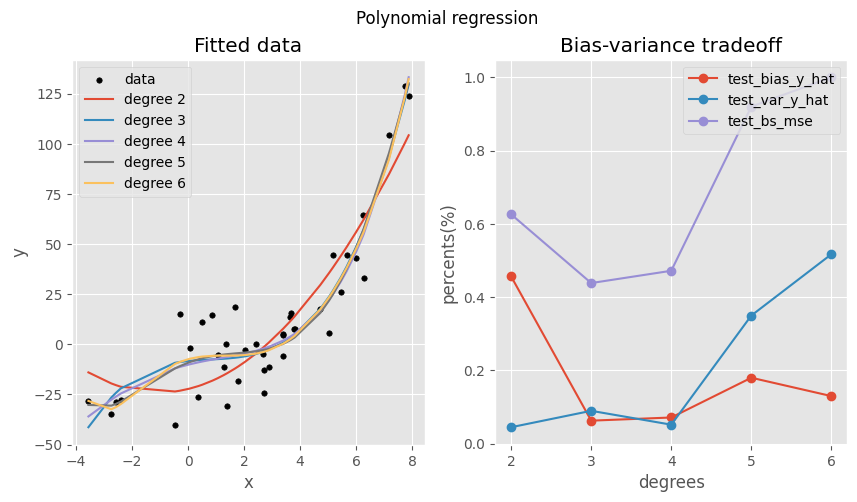

In [5]:
plot(cv_scores, degrees, x, y, y_hats, title="Polynomial regression")

In [6]:
# degrees = [1, 2, 10]
# degrees = range(1, 11)
degrees = range(2, 7)
pf = PolynomialFeatures()
estimator = RidgeRegression(transformer=pf, alpha=10e3)
bs_sampler = Sampler(type="residuals", estimator=estimator)
bs = Bootstrap(estimator, bs_sampler, n_bootstraps=100)
n_cv_splits = 4


cv_scores: dict[str, np.ndarray] = {}
y_hats: list[np.ndarray] = []
for i, degree in enumerate(degrees):
    # set degree of polynomial features
    pf.degree = degree
    # calculate cv scores
    score = kfold_cross_validation(bs, x, y, f, n_cv_splits)
    # estimate w_hat on all data
    y_hats.append(estimator.fit(x, y).predict(x).flatten())
    # fill cv_scores dict
    for k, v in score.items():
        if k not in cv_scores.keys():
            cv_scores[k] = np.zeros(len(degrees))
        cv_scores[k][i] = v

# print(pd.DataFrame(cv_scores.values(), index=list(cv_scores.keys()), columns=degrees))
pd.DataFrame(cv_scores, index=degrees)

,test_r2,test_adj_r2,test_mse,test_bs_mse,test_bias_y_hat,test_var_y_hat,test_cond_num,train_r2,train_adj_r2,train_mse,train_bs_mse,train_bias_y_hat,train_var_y_hat,train_cond_num
2,-0.197155,-0.539200,1125.555853,1336.773472,1041.710675,4.403663,32.203363,0.395776,0.351019,879.501303,1044.890660,790.406478,4.300921,32.203363
3,-0.436672,-1.155009,641.407786,662.964699,425.062742,8.337781,293.411846,0.618033,0.573960,571.258555,560.728983,381.044309,5.426988,293.411846
4,-0.208409,-1.175136,565.090937,570.613206,383.678955,18.571345,2493.749946,0.620496,0.559775,556.316064,545.518503,354.802183,8.453064,2493.749946
5,0.131740,-0.953584,545.101370,574.841518,336.567580,17.156544,20689.720055,0.678391,0.611389,485.470204,478.576499,263.594870,13.984612,20689.720055
6,0.383457,-0.849629,489.696755,490.692098,202.625754,29.677312,198385.175214,0.714067,0.639476,425.496205,418.546694,192.937725,16.725856,198385.175214


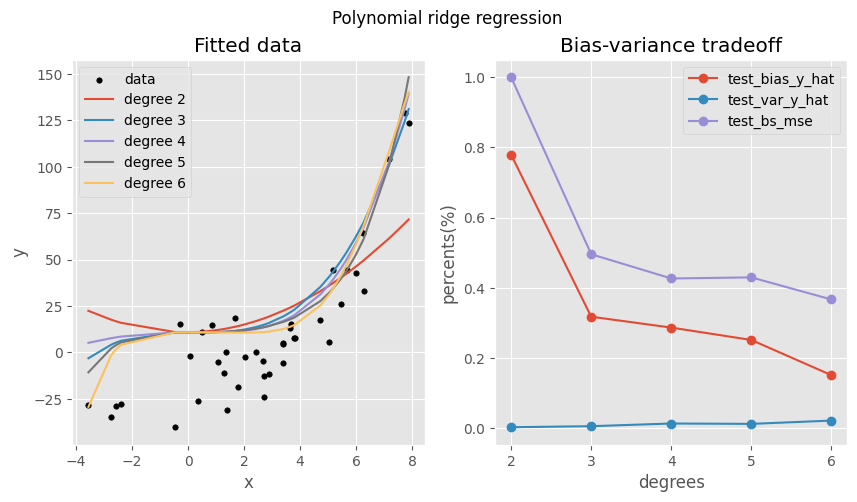

In [7]:
plot(cv_scores, degrees, x, y, y_hats, title="Polynomial ridge regression")

In [8]:
# degrees = [1, 2, 10]
# degrees = range(1, 11)
degrees = range(2, 7)
pf = PolynomialFeatures()
estimator = LassoRegression(transformer=pf, alpha=10e3)
bs_sampler = Sampler(type="residuals", estimator=estimator)
bs = Bootstrap(estimator, bs_sampler, n_bootstraps=100)
n_cv_splits = 4


cv_scores: dict[str, np.ndarray] = {}
y_hats: list[np.ndarray] = []
for i, degree in enumerate(degrees):
    # set degree of polynomial features
    pf.degree = degree
    # calculate cv scores
    score = kfold_cross_validation(bs, x, y, f, n_cv_splits)
    print(bs.get_w_hat().flatten())
    # estimate w_hat on all data
    y_hats.append(estimator.fit(x, y).predict(x).flatten())
    # fill cv_scores dict
    for k, v in score.items():
        if k not in cv_scores.keys():
            cv_scores[k] = np.zeros(len(degrees))
        cv_scores[k][i] = v

# print(pd.DataFrame(cv_scores.values(), index=list(cv_scores.keys()), columns=degrees))
pd.DataFrame(cv_scores, index=degrees)

[0. 0. 0.]
[0. 0. 0. 0.]
[0.         0.         0.         0.         0.01190872]
[0.         0.         0.         0.         0.         0.00438244]
[0.         0.         0.         0.         0.         0.
 0.00070902]


,test_r2,test_adj_r2,test_mse,test_bs_mse,test_bias_y_hat,test_var_y_hat,test_cond_num,train_r2,train_adj_r2,train_mse,train_bs_mse,train_bias_y_hat,train_var_y_hat,train_cond_num
2,-0.190159,-0.530204,1618.938366,1618.938366,1317.534937,0.000000,32.209159,-0.088316,-0.168932,1618.938366,1618.938366,1317.534937,0.000000,32.209159
3,-0.088234,-0.632351,1618.938366,1618.938366,1317.534937,0.000000,293.646870,-0.080093,-0.204719,1618.938366,1618.938366,1317.534937,0.000000,293.646870
4,0.649196,0.368553,387.440717,863.613141,609.103291,17.621178,2524.860513,0.745112,0.704329,373.213630,751.061528,493.598156,14.411632,2524.860513
5,0.733132,0.399546,310.918123,318.667286,117.880492,13.408731,20301.916354,0.799975,0.758303,293.924067,306.610856,115.215790,11.315578,20301.916354
6,0.689723,0.069169,387.917432,403.439234,195.475492,14.385235,182294.741464,0.770621,0.710783,340.005065,352.158613,158.387953,12.072751,182294.741464


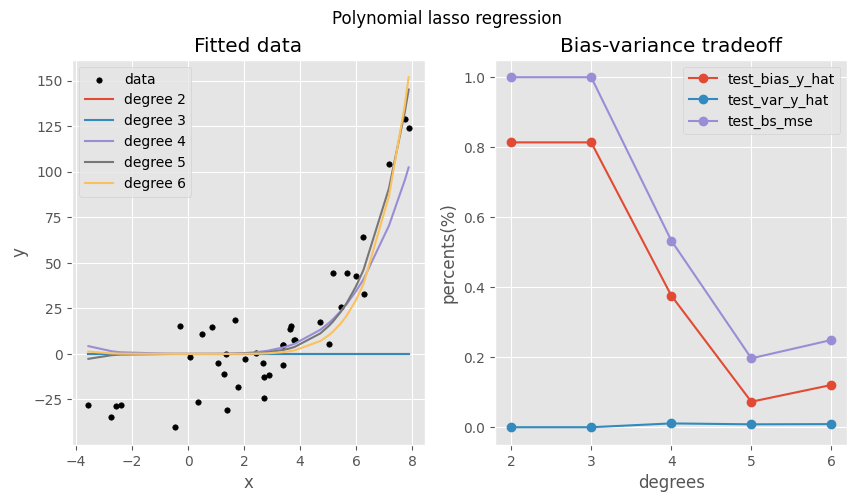

In [9]:
plot(cv_scores, degrees, x, y, y_hats, title="Polynomial lasso regression")




In [10]:
# def plot(x: np.ndarray, y: np.ndarray, label: str) -> None:
#     # sort the values of x before line plot
#     data: np.ndarray = np.concatenate([x, y], axis=1)
#     data = data[np.argsort(data[:, 0], axis=0), :]

#     plt.plot(data[:, 0], data[:, 1], color=next(colors_cycle), label=label)

In [11]:
# degrees: list[int] = [1, 2, 3, 4, 15, 20]
# models_residuals: list[np.ndarray] = []

# for degree in degrees:
#     # generate X (i poly features for x)
#     polynomial_features: PolynomialFeatures = PolynomialFeatures(degree=degree)
#     X: np.ndarray = polynomial_features.fit_transform(data[:, 0])

#     # train-test split

#     # check condition number
#     condition_number = np.linalg.cond(X)

#     # X^*
#     try:
#         # https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html
#         X_pseudo_inverse: np.ndarray = np.linalg.pinv(X)
#     except LinAlgError as e:
#         print(f"SVD computation does not converge for {str(X)}")
#         raise e

#     # w_hat = X^* * y
#     w_hat: np.ndarray = X_pseudo_inverse @ y
#     # y_hat = X * w
#     y_hat: np.ndarray = X @ w_hat

#     # metrics
#     # adjusted coefficient of determination
#     r2: np.float64 = np.float64(r2_score(y, y_hat))
#     adj_r2: np.float64 = 1 - (1 - r2) * (y_hat.shape[0] - 1) / (
#         y_hat.shape[0] - degree - 1
#     )

#     # predictions variance
#     var_y_hat: np.float64 = np.var(y_hat)

#     # bias^2 = SSE - var(y_hat) - var(y)
#     SSE: np.float64 = np.mean((y - y_hat) ** 2)
#     sqared_bias: np.float64 = SSE - var_y_hat - np.var(y)

#     print(
#         f" \
#         polynomial degree: {degree},\n \
#         condition_number:  {condition_number:.2f},\n \
#         var_y_hat:         {var_y_hat:.2f},\n \
#         sqared_bias:       {sqared_bias:.2f},\n \
#         SSE:               {SSE:.2f},\n \
#         R2:                {r2:.2f},\n \
#         adj. R2:           {adj_r2:.8f}\n \
#         w_hat: {np.squeeze(w_hat).round(2)}\n"
#     )

#     # plot
#     plot(x, y_hat, f"poly degree: {degree}")

#     # metadata
#     models_residuals.append(np.squeeze(y - y_hat))

# plt.scatter(x, y, s=15, c="black", marker="o", label="data")
# plt.legend(loc="upper left", prop={"size": 10})
# plt.title("Fitted polynomial regressions")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.show()

## QQPlot of residuals

In [12]:
# for i, degree in enumerate(degrees):
#     fig = sm.qqplot(
#         models_residuals[i], line="45", fit=True, label=f"poly degree: {degree}"
#     )
#     plt.legend(loc="upper left", prop={"size": 10})
#     plt.show(fig)